# 001. Photoluminescence and Absorption of Triplet Transitions in the Nitrogen-Vacancy Center in Diamond Using Huang-Rhys Theory

In this notebook, we demonstrate how to use `PyPL` to compute vibrationally resolved photoluminescence (PL) and absorption spectra associated with the transition between the triplet excited state ($^3E$) and the triplet ground state ($^3A_2$) of the negatively charged nitrogen-vacancy center $\text{NV}^-$ in diamond, using the Huang-Rhys theory and the generating function approach. [[1]](https://iopscience.iop.org/article/10.1088/1367-2630/16/7/073026/meta) [[2]](https://doi.org/10.1103/PhysRevMaterials.5.084603)

The notebook is organized into four parts:

1. Photoluminescence spectrum from atomic displacements

2. Photoluminescence spectrum from forces

3. Absorption spectrum from atomic displacements

4. Temperature-dependent photoluminescence spectrum

## 1. Photoluminescence spectrum from atomic displacements

To compute the vibrationally resolved photoluminescence (PL) spectrum for the ${}^3\!E \to {}^3\!A_2$ transition of the $\text{NV}^-$ center in diamond, we require the equilibrium atomic coordinates of both the ${}^3\!A_2$ and ${}^3\!E$ states, as well as the phonon frequencies and eigenmodes evaluated at the equilibrium geometry of the ${}^3\!A_2$ state.

The equilibrium coordinates of the ${}^3\!A_2$ ground state can be obtained from a density functional theory (DFT) calculation, for example, using [Quantum ESPRESSO](https://www.quantum-espresso.org/) code. Input and pseudopotential files for this calculation are provided in the `001_nv_diamond_abs_pl/gs_dft` directory. The relevant output file is `001_nv_diamond_abs_pl/gs_dft/pwscf.xml`, which contains the optimized atomic positions.

The equilibrium coordinates of the ${}^3\!E$ excited state are obtained via a constrained-occupation DFT ($\Delta\mathrm{SCF}$) calculation. The corresponding input and output files are located in `001_nv_diamond_abs_pl/es_dft/`.

Phonon frequencies and eigenmodes at the ${}^3\!A_2$ equilibrium geometry are computed using the frozen-phonon approach with the [Phonopy](https://phonopy.github.io/phonopy/) package. The detailed procedure is described in `001_nv_diamond_abs_pl/phonopy_files/phonopy.txt`, and the resulting data are stored in `001_nv_diamond_abs_pl/phonopy_files/gs_ph_mesh.hdf5`.

**Note**: The atoms in the ground-state DFT and excited-state $\Delta\mathrm{SCF}$ calculations must appear in the same order to ensure correct mapping of displacements and phonon modes.

In [41]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import sys
sys.path.insert(0, '/Users/jinyuchem/Desktop/Plots-For-Presentation/pypl/pypl/')

from pypl.hr_solver import hr_solver
from pypl.utils import *
import os

path = os.getcwd()
os.chdir(path)

In [42]:
gs_phonon_file = '001_nv_diamond_abs_pl/phonopy_files/gs_ph_mesh.hdf5'
gs_file = '001_nv_diamond_abs_pl/gs_dft/pwscf.xml'
es_file = '001_nv_diamond_abs_pl/es_cdft/pwscf.xml'

`PyPL` provides utility functions to extract and process data from these files.

In [43]:
# Unit of freqs is THz
gs_phonon_freqs, gs_phonon_modes = parse_phonopy_h5(gs_phonon_file)
# Unit of coordinates and cell_parameters is Angstrom
atomic_symbols, gs_coord, cell_parameters = parse_atoms_qexml(gs_file)
atomic_symbols_2, es_coord, cell_parameters_2 = parse_atoms_qexml(es_file)

# Ensure that both sets of atomic coordinates have consistent atomic symbols and cell parameters.
assert atomic_symbols == atomic_symbols_2, "Mismatch in atomic symbols between ground-state and excited-state structures."
assert np.max(np.abs(cell_parameters - cell_parameters_2)) < 1e-12, "Mismatch in cell parameters between ground-state and excited-state structures."

Atomic masses must also be specified for all elements in the system; otherwise, `PyPL` will fall back to its default values.

In [44]:
mass_list = {'C': 12.0107, 'N': 14.0067}

We begin by computing the partial Huang–Rhys (HR) factor, which quantifies the coupling between the electronic transition and a specific phonon mode. This factor is then used to evaluate the vibrationally resolved photoluminescence (PL) spectrum via the generating function approach. The partial HR factor for phonon mode $k$ is given by:
\begin{equation}
S_k = \frac{\omega_k \Delta Q_k^2}{2\hbar}
\end{equation}
where $\Delta Q_k$ is the mass-weighted displacement along mode $k$. It is evaluated as
\begin{equation}
\Delta Q_k = \sum_{\alpha=1}^N\sum_{i=x,y,z}\sqrt{M_{\alpha}} \Delta R_{\alpha i} e_{k,\alpha i}.
\end{equation}
Here, $\Delta R_{\alpha i} = R_{\alpha i}^{\text{ES}} - R_{\alpha i}^{\text{GS}}$ is the Cartesian displacement of atom ${\alpha}$ along direction $i$ between the excited-state (ES, ${{}^3\!E}$) and ground-state (GS, ${}^3\!A_2$) geometries, $M_\alpha$ is the atomic mass, and $e_{k,\alpha i}$ is the eigenvector component of phonon mode $k$.

In [45]:
pl_use_dis = hr_solver()
hrf_dict_pl_dis = pl_use_dis.compute_hrf_dis(gs_phonon_freqs, gs_phonon_modes, atomic_symbols, gs_coord, es_coord, cell_parameters, mass_list=mass_list)

Computing Huang-Rhys factors using atomic displacements.
Total \Delta Q is  6.529832366847e-01 amu^{0.5} \AA
Total Huang-Rhys factor is  2.985289195896e+00


`hrf_dict_pl_dis` is a dictionary that contains the phonon frequencies (in rad/s) and the corresponding partial Huang–Rhys (HR) factors. We can inspect the phonon modes with the strongest electron–phonon coupling as follows:

In [46]:
indices = np.argsort(hrf_dict_pl_dis['hr_factors'])[-10:]
for i in indices[::-1]:
    print('index %4d  freq: % .4f meV    hrf: % .4e' % (i + 1, hrf_dict_pl_dis['freqs'][i] * constants.hbar / constants.eV * 1e3, hrf_dict_pl_dis['hr_factors'][i]))

index   64  freq:  62.3239 meV    hrf:  8.3595e-01
index    6  freq:  34.4922 meV    hrf:  3.5594e-01
index   36  freq:  49.0021 meV    hrf:  3.2950e-01
index  252  freq:  81.4371 meV    hrf:  1.0780e-01
index   30  freq:  48.2382 meV    hrf:  8.3555e-02
index  144  freq:  70.7789 meV    hrf:  7.6982e-02
index    5  freq:  34.3174 meV    hrf:  6.6586e-02
index   17  freq:  42.5984 meV    hrf:  6.2820e-02
index  122  freq:  68.2145 meV    hrf:  5.7055e-02
index  321  freq:  89.3907 meV    hrf:  4.9803e-02


We can compute the spectral density of the HR factors defined as
\begin{equation}
S(\hbar\omega) = \sum_k S_k \delta(\hbar\omega - \hbar\omega_k),
\end{equation}
In practice, the Dirac $\delta$-function is approximated by a Gaussian to account for the participation of a continuum of phonon modes. The Gaussian broadening is interpolated from the values specified in `sigma` (given in meV).

In [47]:
sigmas = [
    [3, 2], [3, 4], [3, 6],
    [6, 2], [6, 4], [6, 6],
]

spectral_density_pl_dis = []
for i, sigma in enumerate(sigmas):
    tmp = pl_use_dis.compute_spectral_density(hrf_dict_pl_dis, energy_axis=np.linspace(0, 200, 201), sigma=sigma)
    spectral_density_pl_dis.append(tmp)

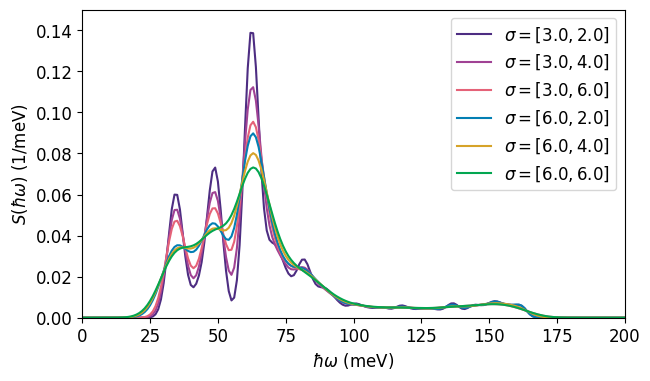

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

colors=[
    "#4D2D82",  # Deep Violet
    "#A04294",  # Vibrant Purple
    "#E56278",  # Soft Coral
    "#037FB3",  # Ocean Blue
    "#D6A329",  # Goldenrod Yellow
    "#02A650",  # Emerald Green
]

for i in range(len(spectral_density_pl_dis)):
    ax.plot(spectral_density_pl_dis[i][0], spectral_density_pl_dis[i][1], color=colors[i],
            label=r'$\sigma=[%.1f, %.1f]$' % (sigmas[i][0], sigmas[i][1]))

ax.legend()
ax.set_xlabel('$\hbar\omega$ (meV)')
ax.set_ylabel('$S(\hbar\omega)$ (1/meV)')
ax.set_ylim([0, 0.15])
ax.set_xlim([0, 200])

plt.show()

With the HR factors, we then compute the lineshape function. The line shape function (or the spectral function) is computed using the generating function approach
\begin{equation}
A(\hbar\omega, T) = \frac{1}{2\pi \hbar} \int e^{it} G(t, T) e^{-\frac{\lambda|t|}{\hbar}} \mathrm{d}t,
\end{equation}
where $\lambda$ is the parameter describing the broadening of the zero-phonon line (ZPL).

Here, we compute the lineshape function using the Fast Fourier Transform (FFT) approach. 

In [49]:
linshape_fft_pl_dis = pl_use_dis.compute_lineshape_fft(hrf_dict_pl_dis, temp=4, sigma=[6, 2], zpl_broadening=0.3)

time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.999999999865


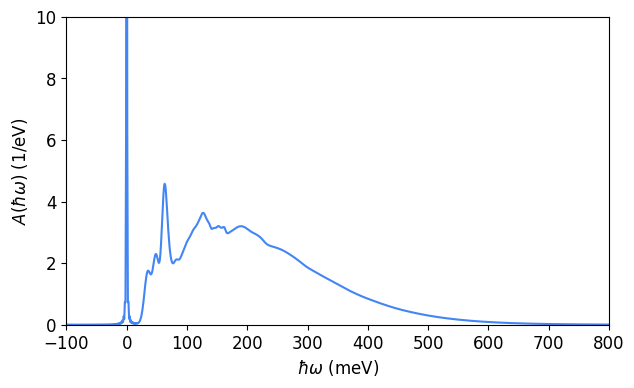

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.plot(linshape_fft_pl_dis[0], linshape_fft_pl_dis[1], color='#4285F4')

ax.set_xlabel('$\hbar\omega$ (meV)')
ax.set_ylabel('$A(\hbar\omega)$ (1/eV)')
ax.set_ylim([0, 10])
ax.set_xlim([-100, 800])

plt.show()

From the lineshape function, the PL spectrum can be obtained. Compared to the lineshape, the PL spectrum includes a $(\hbar\omega)^3$ prefactor and is shifted to align with the zero-phonon line (ZPL).
\begin{equation}
I(\hbar\omega) \propto (\hbar\omega)^3 A(E_{\text{ZPL}} - \hbar\omega, T).
\end{equation}

Due to the proportionality relation, the calculation yields the relative intensity of the PL spectrum rather than its absolute intensity.

In [51]:
ezpl = 1945 # meV
spectrum_pl_dis = pl_use_dis.compute_spectrum(ezpl, spectrum_type='PL', lineshape=linshape_fft_pl_dis)

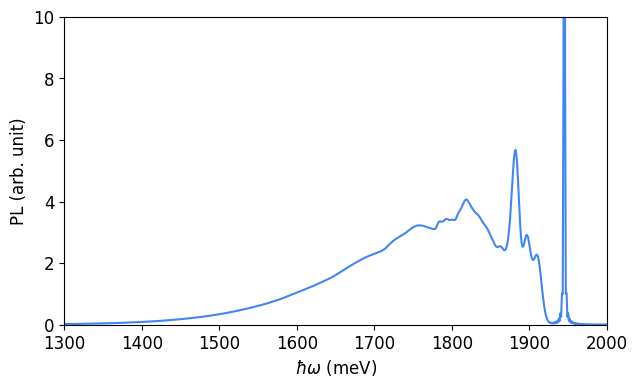

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.plot(spectrum_pl_dis[0], spectrum_pl_dis[1], color='#4285F4')

ax.set_xlabel('$\hbar\omega$ (meV)')
ax.set_ylabel('PL (arb. unit)')
ax.set_xlim([1300, 2000])
ax.set_ylim([0, 10])

plt.show()

## 2. Photoluminescence spectrum from forces

Considering the relation between atomic forces, displacements, and the Hessian within the harmonic approximation, the Huang–Rhys (HR) factors and the PL spectrum can also be computed from atomic forces.

In this approach, we evaluate the forces on the ground-state ${}^3\!A_2$ potential energy surface at the equilibrium geometry of the excited state ${}^3\!E$. These forces are obtained from a single-point DFT calculation, using the input file `001_nv_diamond_abs_pl/gs_forces_at_es_coord/pw.in` and the corresponding output file `001_nv_diamond_abs_pl/gs_forces_at_es_coord/pwscf.xml`.

In [53]:
forces_fname = '001_nv_diamond_abs_pl/gs_forces_at_es_coord/pwscf.xml'
atomic_symbols, gs_forces_es_coord = parse_forces_qexml(forces_fname)

With the atomic forces, the mass-weighted displacement $\Delta Q_k$ is evaluated using as
\begin{equation}
\Delta Q_k = \frac{1}{\omega_k^2}\sum_{\alpha=1}^N\sum_{i=x,y,z}\frac{F_{\alpha i}e_{k, \alpha i}}{\sqrt{M_{\alpha}}}.
\end{equation}
Here, $F$ is the ground state forces computed at the equilibrium geometry of the excited state. Then the partial Huang-Rhys (HR) factors are computed as
\begin{equation}
S_k = \frac{\omega_k \Delta Q_k^2}{2\hbar}
\end{equation}

In [54]:
pl_using_forces = hr_solver()
hrf_dict_pl_forces = pl_using_forces.compute_hrf_forces(gs_phonon_freqs, gs_phonon_modes, atomic_symbols, gs_forces_es_coord, mass_list)

Computing Huang-Rhys factors using atomic forces.

Total \Delta Q is  6.457015502724e-01 amu^{0.5} \AA
Total Huang-Rhys factor is  2.942036506241e+00



Using the partial HR factors, we can in the same way construct the lineshape function and obtain the PL spectrum.

In [55]:
lineshape_fft_pl_forces = pl_using_forces.compute_lineshape_fft(hrf_dict_pl_forces, temp=4, sigma=[6, 2], zpl_broadening=0.3)
spectrum_pl_forces = pl_using_forces.compute_spectrum(ezpl, lineshape=lineshape_fft_pl_forces, spectrum_type='PL')


time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.9999999998737


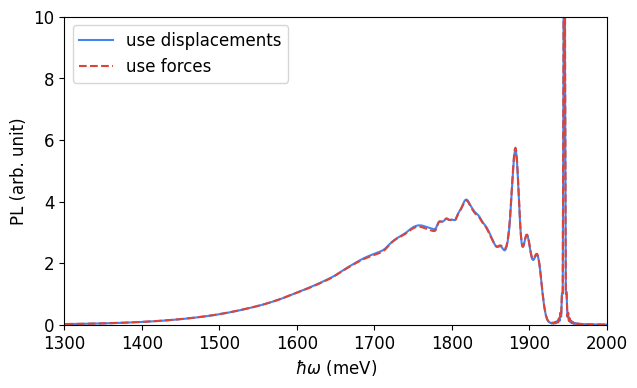

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(spectrum_pl_dis[0], spectrum_pl_dis[1], label='use displacements', color='#4285F4')
ax.plot(spectrum_pl_forces[0], spectrum_pl_forces[1], label='use forces', linestyle='--', color='#DB4437')

ax.legend()
ax.set_xlabel('$\hbar\omega$ (meV)')
ax.set_ylabel('PL (arb. unit)')
ax.set_xlim([1300, 2000])
ax.set_ylim([0, 10])

plt.show()

The PL spectra obtained from the two approaches are nearly identical, indicating that the ground-state potential energy surface is well described by the harmonic approximation.

## 3. Absorption spectrum from atomic displacements

The Huang–Rhys theory combined with the generating function approach can also be applied to compute vibrationally resolved absorption spectra. Here, we evaluate the vibrationally resolved absorption spectrum of the ${}^3\!A_2 \to {}^3\!E$ transition of the $\text{NV}^-$ center in diamond.

For this calculation, the phonon frequencies and eigenmodes of the ${}^3\!E$ state are required, as provided in the file `001_nv_diamond_abs_pl/phonopy_files/es_ph_mesh.hdf5`. The atomic displacements between the ${}^3\!A_2$ and ${}^3\!E$ states are used.

In [57]:
es_phonon_fname = '001_nv_diamond_abs_pl/phonopy_files/es_ph_mesh.hdf5'
es_phonon_freqs, es_phonon_modes = parse_phonopy_h5(es_phonon_fname)

In [58]:
abs_use_dis = hr_solver()
hrf_dict_abs_dis = abs_use_dis.compute_hrf_dis(es_phonon_freqs, es_phonon_modes, atomic_symbols, gs_coord, es_coord, cell_parameters, mass_list=mass_list)

Computing Huang-Rhys factors using atomic displacements.
Total \Delta Q is  6.529832366847e-01 amu^{0.5} \AA
Total Huang-Rhys factor is  3.102826958964e+00


We can also compute the spectral density and compare with the one for PL.

In [59]:
spectral_density_abs_dis = abs_use_dis.compute_spectral_density(hrf_dict_abs_dis, energy_axis=np.linspace(0, 200, 201), sigma=[6.0, 2.0])

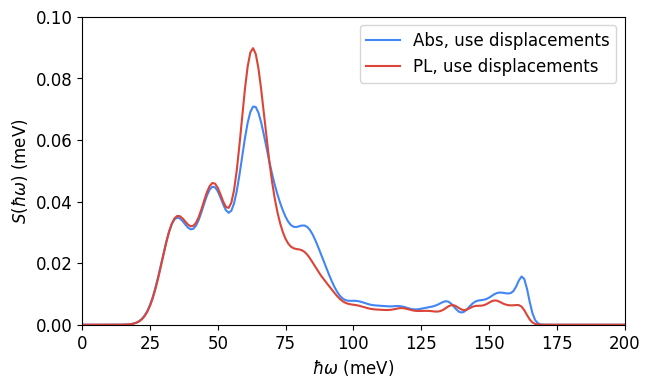

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(spectral_density_abs_dis[0], spectral_density_abs_dis[1], label='Abs, use displacements', color='#4285F4')
ax.plot(spectral_density_pl_dis[3][0], spectral_density_pl_dis[3][1], label='PL, use displacements', color='#DB4437')

ax.legend()
ax.set_xlabel('$\hbar\omega$ (meV)')
ax.set_ylabel('$S(\hbar\omega)$ (meV)')
ax.set_xlim(0, 200)
ax.set_ylim(0.0, 0.1)

plt.show()

The spectral densities for absorption and PL are slightly different, reflecting the differences between the phonon modes of the ground and excited states.

We then compute the lineshape function and the corresponding absorption spectrum. Unlike the PL spectrum, the absorption spectrum includes a $(\hbar\omega)$ prefactor and extends toward higher energies.
\begin{equation}
\sigma(\hbar\omega, T) \propto (\hbar\omega) A(\hbar\omega - E_{\text{ZPL}}, T).
\end{equation}

In [61]:
lineshape_fft_abs_dis = abs_use_dis.compute_lineshape_fft(hrf_dict_abs_dis, temp=4, sigma=[6.0, 2.0], zpl_broadening=0.3)
spectrum_abs_dis = abs_use_dis.compute_spectrum(ezpl, spectrum_type='Abs', lineshape=lineshape_fft_abs_dis)

time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.9999999998641


We can compare together the PL and the absorption spectra.

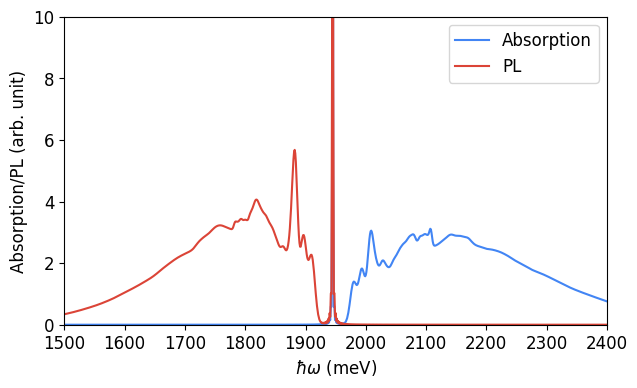

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(spectrum_abs_dis[0], spectrum_abs_dis[1], label='Absorption', color='#4285F4')
ax.plot(spectrum_pl_dis[0], spectrum_pl_dis[1], label='PL', color='#DB4437')

ax.legend()
ax.set_xlabel('$\hbar\omega$ (meV)')
ax.set_ylabel('Absorption/PL (arb. unit)')
ax.set_xlim(1500, 2400)
ax.set_ylim([0, 10])

plt.show()

The mirror symmetry between the PL and absorption spectra does not hold strictly, due to the differences between the phonon modes of the ground and excited states and the difference in the prefactor.

## 4. Temperature-dependent photoluminescence spectrum

Here, we use PyPL to compute the temperature-dependent PL spectra.

In [63]:
temp_pl_forces = hr_solver()
hrf_dict_temp_pl_forces = temp_pl_forces.compute_hrf_forces(gs_phonon_freqs, gs_phonon_modes, atomic_symbols, gs_forces_es_coord, mass_list)

Computing Huang-Rhys factors using atomic forces.

Total \Delta Q is  6.457015502724e-01 amu^{0.5} \AA
Total Huang-Rhys factor is  2.942036506241e+00



It is necessary to provide the temperature-dependent broadening parameter for the ZPL.

In [64]:
temps = [8, 150, 200, 250, 300]
zpl_broadenings = [0.3, 0.8, 1.8, 3.2, 4.8]
temp_pls = []

for t, l in zip(temps, zpl_broadenings):
    tmp_lineshape = temp_pl_forces.compute_lineshape_fft(hrf_dict_temp_pl_forces, temp=t, sigma=[6.0, 2.0], zpl_broadening=l)
    tmp_spectrum = temp_pl_forces.compute_spectrum(ezpl, spectrum_type='PL', lineshape=tmp_lineshape)
    temp_pls.append(tmp_spectrum)

time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.9999999998737
time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.9999999998736
time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.999999999874
time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.9999999998735
time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV

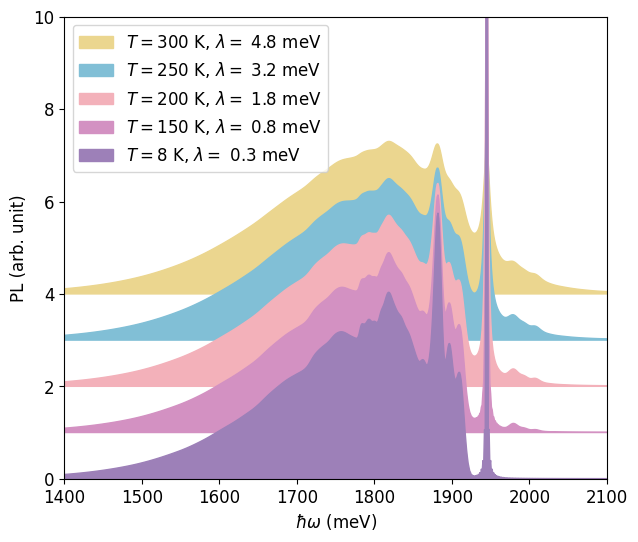

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

colors=[
    "#9D80B8",  # Deep Violet
    "#D391C2",  # Vibrant Purple
    "#F3B1BA",  # Soft Coral
    "#81BFD6",  # Ocean Blue
    "#EBD68F",  # Goldenrod Yellow
]

for i in range(len(temps)-1, -1, -1):
    ax.fill_between(temp_pls[i][0], 1*i, temp_pls[i][1] + 1*i, color=colors[i],
                    label='$T = %d$ K, $\lambda =$ %.1f meV'%(temps[i], zpl_broadenings[i]))

ax.legend(loc='upper left')
ax.set_xlabel('$\hbar\omega$ (meV)')
ax.set_ylabel('PL (arb. unit)')
ax.set_xlim([1400, 2100])
ax.set_ylim([0, 10])

plt.show()

As the temperature increases, the PL lineshape becomes smoother. The intensity of the phonon sideband at energies higher than the ZPL also increases, indicating that higher vibrational levels of the excited state are being populated.